In [1]:
from essential_generators import DocumentGenerator
import sqlalchemy as sa
from sqlalchemy.sql import text
from sqlalchemy.orm import sessionmaker
import uuid
import random
import time

In [2]:
# User customizable stuff
server = "mssql.ad.tdt"
database = "sqlHeapTest"
numRecords = 45000
results = []

# Helper Functions, ignore

In [3]:
gen = DocumentGenerator()

def executeScript(eng: sa.engine.Engine, file: str):
    with eng.connect() as con:
        with open(file) as sql_file:
            sql_command = ''
            # Iterate over all lines in the sql file
            for line in sql_file:
                # Ignore commented lines
                if not line.startswith('--') and line.strip('\n'):
                    # Append line to the command string
                    sql_command += line.strip('\n')

                    # If the command string ends with ';', it is a full statement
                    if sql_command.endswith(';'):
                        # Try to execute statement and commit it
                        try:
                            con.execute(text(sql_command))
                        # Assert in case of error
                        except Exception as e:
                            print(f"Exception raised: {e}")
                        # Finally, clear command string
                        finally:
                            sql_command = ''

insertedValues = {}

def addRecords(maxRecords: int, connection: sa.engine.Connection):
    maxInt = maxRecords * 200
    for x in range(numRecords):
        md = uuid.uuid4().hex
        intValue = random.randint(0, maxInt)
        if intValue in insertedValues:
            continue
        insertedValues[intValue] = None
        randString = gen.gen_sentence()
        sql = text("insert into testTable(intColumn, md5, string) VALUES (:intcol, :md5, :strval)")
        connection.execute(sql, intcol=intValue, md5=md, strval=randString)
    print(f"Number of records attempted to be inserted: {numRecords}")

def timeInstance(func):
    tic = time.perf_counter()
    func()
    toc = time.perf_counter()
    duration = f"{toc-tic:0.4f}"
    print(f"Completed in {duration} seconds")
    return duration

# Setup database for testing
Connect to the base, and run the setupDB.sql contents

In [4]:
engine = sa.create_engine(f"mssql+pyodbc://{server}/TempDB?Driver=ODBC+Driver+18+for+SQL+Server&Trusted_Connection=yes&TrustServerCertificate=Yes", connect_args = {'autocommit':True})

/var/folders/d7/4cl_f7wd7y5_c9gcsjbt78y80000gn/T/ipykernel_79180/3657996963.py:1: SAWarning: No driver name specified; this is expected by PyODBC when using DSN-less connections
  engine = sa.create_engine(f"mssql+pyodbc://{server}/TempDB?Driver=ODBC+Driver+18+for+SQL+Server&Trusted_Connection=yes&TrustServerCertificate=Yes", connect_args = {'autocommit':True})


In [5]:
executeScript(engine, "setupDB.sql")

# Setup Fixture Data
Using the newly created setup, connect and insert some test records

In [6]:
engine = sa.create_engine(f"mssql+pyodbc://{server}/{database}?Driver=ODBC+Driver+18+for+SQL+Server&Trusted_Connection=yes&TrustServerCertificate=Yes")
conn = engine.connect()
conn

/var/folders/d7/4cl_f7wd7y5_c9gcsjbt78y80000gn/T/ipykernel_79180/2762592990.py:1: SAWarning: No driver name specified; this is expected by PyODBC when using DSN-less connections
  engine = sa.create_engine(f"mssql+pyodbc://{server}/{database}?Driver=ODBC+Driver+18+for+SQL+Server&Trusted_Connection=yes&TrustServerCertificate=Yes")


In [7]:
addRecords(numRecords, conn)

Number of records attempted to be inserted: 45000


# Test 1
Setup a clustered index, timing how long it takes on one column

In [36]:
t = timeInstance(lambda: executeScript(engine, "test1.sql"))
results.append({
    "Test": "Test 1",
    "Description": "Create clustered Index, one column",
    "Time (s)": t
})

Completed in 0.8263 seconds


# Test 2
Remove the clustered index, timing how long it takes

In [38]:
t = timeInstance(lambda: executeScript(engine, "test2.sql"))
results.append({
    "Test": "Test 2",
    "Description": "Drop single-column Clustered Index",
    "Time (s)": t
})

Completed in 0.0266 seconds


# Test 3
Insert another bunch of records and re-add the clustered index

In [10]:
addRecords(numRecords, conn)

Number of records attempted to be inserted: 45000


In [11]:
t = timeInstance(lambda: executeScript(engine, "test1.sql"))
results.append({
    "Test": "Test 3",
    "Description": "Create clustered Index, one column, extra records",
    "Time (s)": t
})

Exception raised: (pyodbc.ProgrammingError) ('42S11', "[42S11] [Microsoft][ODBC Driver 18 for SQL Server][SQL Server]The operation failed because an index or statistics with name 'IX_testTable' already exists on table 'dbo.testTable'. (1913) (SQLExecDirectW)")
[SQL: CREATE CLUSTERED INDEX IX_testTable    ON dbo.testTable (intColumn);]
(Background on this error at: https://sqlalche.me/e/14/f405)
Completed in 0.0051 seconds


# Test 4
Drop the clustered index, again timing

In [12]:
t = timeInstance(lambda: executeScript(engine, "test2.sql"))
results.append({
    "Test": "Test 4",
    "Description": "Drop single-column Clustered Index, extra records",
    "Time (s)": t
})

Completed in 0.0009 seconds


# Second Test!  With 2 columns in index

# Prep Database

In [13]:
engine = sa.create_engine(f"mssql+pyodbc://{server}/TempDB?Driver=ODBC+Driver+18+for+SQL+Server&Trusted_Connection=yes&TrustServerCertificate=Yes", connect_args = {'autocommit':True})
executeScript(engine, "setupDB.sql")

/var/folders/d7/4cl_f7wd7y5_c9gcsjbt78y80000gn/T/ipykernel_79180/2932847717.py:1: SAWarning: No driver name specified; this is expected by PyODBC when using DSN-less connections
  engine = sa.create_engine(f"mssql+pyodbc://{server}/TempDB?Driver=ODBC+Driver+18+for+SQL+Server&Trusted_Connection=yes&TrustServerCertificate=Yes", connect_args = {'autocommit':True})


In [14]:
engine = sa.create_engine(f"mssql+pyodbc://{server}/{database}?Driver=ODBC+Driver+18+for+SQL+Server&Trusted_Connection=yes&TrustServerCertificate=Yes")
conn = engine.connect()
conn

/var/folders/d7/4cl_f7wd7y5_c9gcsjbt78y80000gn/T/ipykernel_79180/2762592990.py:1: SAWarning: No driver name specified; this is expected by PyODBC when using DSN-less connections
  engine = sa.create_engine(f"mssql+pyodbc://{server}/{database}?Driver=ODBC+Driver+18+for+SQL+Server&Trusted_Connection=yes&TrustServerCertificate=Yes")


In [15]:
addRecords(numRecords, conn)

Number of records attempted to be inserted: 45000


# Test 5
Setup a clustered index, two columns, seeing how long it takes

In [16]:
t = timeInstance(lambda: executeScript(engine, "test3.sql"))
results.append({
    "Test": "Test 5",
    "Description": "Create clustered Index, two columns",
    "Time (s)": t
})

Completed in 1.4826 seconds


# Test 6
Remove the clustered index, timing how long it takes

In [17]:
t = timeInstance(lambda: executeScript(engine, "test2.sql"))
results.append({
    "Test": "Test 6",
    "Description": "Drop dual-column Clustered Index",
    "Time (s)": t
})

Completed in 0.0011 seconds


# Test 7
Insert another bunch of records and re-add the clustered index

In [18]:
addRecords(numRecords, conn)

Number of records attempted to be inserted: 45000


In [19]:
t = timeInstance(lambda: executeScript(engine, "test3.sql"))
results.append({
    "Test": "Test 7",
    "Description": "Create clustered Index, 2 columns, extra records",
    "Time (s)": t
})

Exception raised: (pyodbc.ProgrammingError) ('42S11', "[42S11] [Microsoft][ODBC Driver 18 for SQL Server][SQL Server]The operation failed because an index or statistics with name 'IX_testTable' already exists on table 'dbo.testTable'. (1913) (SQLExecDirectW)")
[SQL: CREATE CLUSTERED INDEX IX_testTable    ON dbo.testTable (intColumn, md5);]
(Background on this error at: https://sqlalche.me/e/14/f405)
Completed in 0.0038 seconds


# Test 8
Drop the clustered Index, again timing

In [20]:
t = timeInstance(lambda: executeScript(engine, "test2.sql"))
results.append({
    "Test": "Test 8",
    "Description": "Drop dual-column Clustered Index, extra records",
    "Time (s)": t
})

Completed in 0.0009 seconds


# Plot Results

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [22]:
pdResults = pd.DataFrame.from_dict(results)
pdResults

,Test,Description,Time (s)
0,Test 1,"Create clustered Index, one column",0.9615
1,Test 2,Drop single-column Clustered Index,0.0012
2,Test 3,"Create clustered Index, one column, extra records",0.0051
3,Test 4,"Drop single-column Clustered Index, extra records",0.0009
4,Test 5,"Create clustered Index, two columns",1.4826
5,Test 6,Drop dual-column Clustered Index,0.0011
6,Test 7,"Create clustered Index, 2 columns, extra records",0.0038
7,Test 8,"Drop dual-column Clustered Index, extra records",0.0009


In [32]:
pdResults["Time (s)"] = pdResults["Time (s)"].astype(float)
pdResults["Time"] = pdResults["Time (s)"]
pdResults.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Test         8 non-null      object 
 1   Description  8 non-null      object 
 2   Time (s)     8 non-null      float64
 3   Time         8 non-null      float64
dtypes: float64(2), object(2)
memory usage: 384.0+ bytes


<AxesSubplot:xlabel='Test', ylabel='Time'>

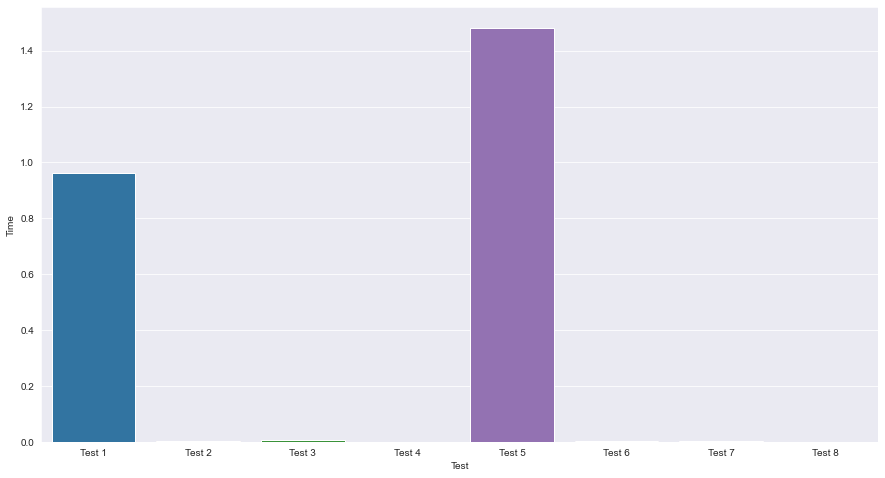

In [34]:
plt.figure(figsize=(15,8))
sns.barplot(data=pdResults, x="Test", y="Time (s)")